#### Libraries Installation
!pip install outlier_utils
!pip install imbalanced-learn 
!pip install delayed
!pip install missingno
!pip install plotly
!pip install lightgbm
!pip install xgboost
!pip install category_encoders
!pip install shap

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# access to the neural network model MLP Classifier
from sklearn.neural_network import MLPClassifier

# classification metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## TRAIN TEST SPLIT

In [2]:
# Read Training Set
df = pd.read_csv('train.csv',dtype={
                             'ip': np.uint8,
                             'app': np.uint8,
                             'device' : np.uint8,
                             'os' : np.uint8,
                             'channel' : np.uint8,
                             'is_attributed' : np.uint8    
                        },parse_dates=['click_time'])

In [3]:
df['day'] = df['click_time'].dt.day.astype('uint8')
# Get oot
#oot = df[df['day']==8]

# Get Train
df = df[df['day']==7]

In [4]:
df['hour'] = df['click_time'].dt.hour.astype('uint8')
df['minute'] = df['click_time'].dt.minute.astype('uint8')
df['second'] = df['click_time'].dt.second.astype('uint8')

#Edit minute variable to two-digit string
df['minute'] = df['minute'].apply(lambda x: '{0:0>2}'.format(x))

In [5]:
click_outlier = 14507.5
ratio_outlier = 812.8342105263157

In [6]:
# Transform

ranges = [-1, 14, 29, 44, np.inf]  # np.inf for infinity
labels = ['1', '2', '3', '4']
df['seconds_grp'] = pd.cut(df['second'], 
                                  bins=ranges, 
                                  labels=labels)
df['interval'] = df['hour'].astype(str) + df['minute'].astype(str) + df['seconds_grp'].astype(str)
#df['interval'] = df['interval'].astype('uint32')

df_interval = df.groupby(
    'interval'
).aggregate(
    {
        'is_attributed':sum,
        'click_time':"count"
    }
).rename(
    columns = {
        'is_attributed': 'total_dl', 
        'click_time': 'total_clicks'
    }, 
    inplace = False)

df_interval['conversion_rate'] = df_interval['total_dl']/df_interval['total_clicks']
df_interval['ratio'] = df_interval['total_clicks']/df_interval['total_dl']
df_interval.reset_index(level=0, inplace=True)

df_interval.loc[(df_interval['total_dl'] == 0) & (df_interval['total_clicks'] > click_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['total_dl'] != 0) & (df_interval['ratio'] > ratio_outlier), 'isFraud'] = 1
df_interval.loc[(df_interval['isFraud'].isnull()), 'isFraud'] = 0

df = pd.merge(df, df_interval[['interval', 'isFraud']], on='interval', how='left')

df.loc[(df['is_attributed'] == 1), 'isFraud'] = 0

df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,seconds_grp,interval,isFraud
0,56,2,1,32,237,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
1,68,3,1,25,168,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
2,142,8,2,13,145,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
3,219,2,1,13,122,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0
4,167,15,1,8,245,2017-11-07,NaN,0,7,0,00,0,1,0001,0.0


In [19]:
df.loc[(df['is_attributed'] == 1)]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day,hour,minute,second,seconds_grp,interval,isFraud
62,155,35,1,13,18,2017-11-07 00:00:00,2017-11-07 01:14:31,1,7,0,00,0,1,0001,0.0
552,24,35,1,13,18,2017-11-07 00:00:00,2017-11-07 01:03:08,1,7,0,00,0,1,0001,0.0
732,90,39,1,13,101,2017-11-07 00:00:00,2017-11-07 03:43:13,1,7,0,00,0,1,0001,0.0
1738,150,35,1,19,21,2017-11-07 00:00:02,2017-11-07 01:45:34,1,7,0,00,2,1,0001,0.0
2227,194,9,1,10,215,2017-11-07 00:00:02,2017-11-07 12:00:36,1,7,0,00,2,1,0001,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59630867,228,72,1,27,101,2017-11-07 23:59:56,2017-11-08 12:15:06,1,7,23,59,56,4,23594,0.0
59631777,174,29,1,19,87,2017-11-07 23:59:57,2017-11-08 01:58:51,1,7,23,59,57,4,23594,0.0
59632107,169,2,1,6,179,2017-11-07 23:59:58,2017-11-08 00:00:40,1,7,23,59,58,4,23594,0.0
59632922,179,19,0,236,213,2017-11-07 23:59:59,2017-11-08 00:00:59,1,7,23,59,59,4,23594,0.0


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state = 280)

In [8]:
print(train.isFraud.sum()/len(train))
print(test.isFraud.sum()/len(test))

0.04238831811089665
0.04238050847756061


In [9]:
train = train.drop(["click_time","attributed_time", "is_attributed", "interval", "day", "seconds_grp"], axis=1)
test = test.drop(["click_time","attributed_time", "is_attributed", "interval", "day", "seconds_grp"], axis=1)

In [10]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=280)

y_train = train['isFraud']
X_train = train.drop('isFraud', axis = 1)

X_train, y_train = rus.fit_resample(X_train, y_train)

from collections import Counter

Counter(y_train)

Counter({0.0: 1769429, 1.0: 1769429})

In [11]:
X_train.to_csv('X_train_15s_v2.csv', index=False)
y_train.to_csv('y_train_15s_v2.csv', index=False)
test.to_csv('test_15s_v2.csv', index=False)

In [ ]:
X_train.to_csv('X_train_15s.csv', index=False)
y_train.to_csv('y_train_15s.csv', index=False)
test.to_csv('test_15s.csv', index=False)

## Data Prep / Feature Engineering

In [2]:
# Read Data From Train-Test Split

X_train = pd.read_csv('X_train_15s.csv')
y_train = pd.read_csv('y_train_15s.csv')
test = pd.read_csv('test_15s.csv')

In [13]:
X_train

,ip,app,device,os,channel,hour,minute,second
0,108,11,1,37,63,9,35,43
1,114,3,1,19,24,5,04,41
2,27,3,1,19,233,10,57,46
3,9,3,1,20,173,9,43,50
4,216,3,1,17,24,5,35,8
...,...,...,...,...,...,...,...,...
3538853,101,12,1,3,245,23,15,19
3538854,75,12,1,8,3,15,07,0
3538855,145,15,1,12,3,21,19,49
3538856,123,24,1,10,105,15,38,56


In [14]:
import category_encoders as ce
cat_features = ['ip', 'app', 'device', 'os', 'channel']
count_enc = ce.CountEncoder(cols=cat_features)
count_enc.fit(X_train[cat_features])

X_train = X_train.join(count_enc.transform(X_train[cat_features]).add_suffix("_count"))
test = test.join(count_enc.transform(test[cat_features]).add_suffix("_count"))

In [15]:
# Define catboost encoder
cbe_encoder = ce.cat_boost.CatBoostEncoder(cols=cat_features, random_state=1234)
  
# Fit encoder and transform the features
cbe_encoder.fit(X_train[cat_features], y_train)

X_train = X_train.join(cbe_encoder.transform(X_train[cat_features]).add_suffix("_cb"))
test = test.join(cbe_encoder.transform(test[cat_features]).add_suffix("_cb"))

In [16]:
feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

In [17]:
X_train = X_train[feature_cols]
X_test = test[feature_cols]

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

scaler.fit(X_test)

StandardScaler()

In [18]:
# Check event rate
print(y_train.sum()/len(y_train))
print(test.isFraud.sum()/len(test))

0.5
0.04238050847756061


## Modelling

In [10]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(max_depth=12,
                        subsample=0.33,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.01)
xgb_model.fit(X_train, y_train)


# save model
import joblib

joblib.dump(xgb_model, 'xgb_count_cat_15s_v2.pkl')

[16:10:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


KeyboardInterrupt: 

In [ ]:
# Prediction - Rounding-off Probability

ypred_lgb = xgb_model.predict(X_train)
predictions_lgb = [round(value) for value in ypred_lgb]
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# evaluate predictions
print("Train Eval")
print("accuracy: ",accuracy_score(y_train,predictions_lgb)*100)
print("auc: ",roc_auc_score(y_train,predictions_lgb)*100)
print("precision_score: ",precision_score(y_train,predictions_lgb)*100)
print("recall_score: ",recall_score(y_train,predictions_lgb)*100)

# Prediction - Rounding-off Probability
ypred_lgb = xgb_model.predict(test[feature_cols])
predictions_lgb = [round(value) for value in ypred_lgb]
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# evaluate predictions
print("Test Eval")
print("accuracy: ",accuracy_score(test['isFraud'],predictions_lgb)*100)
print("auc: ",roc_auc_score(test['isFraud'],predictions_lgb)*100)
print("precision_score: ",precision_score(test['isFraud'],predictions_lgb)*100)
print("recall_score: ",recall_score(test['isFraud'],predictions_lgb)*100)

X_train['prediction']=xgb_model.predict(X_train)
X_train['decile'] = pd.qcut(X_train['prediction'], 10, labels=False)

# At top 2 Decile
X_train['predict_fraud'] = np.where(X_train['decile']>=8, 1, 0)

print("Train Eval at Decile 2")
print("accuracy: ",accuracy_score(y_train,X_train['predict_fraud'])*100)
print("auc: ",roc_auc_score(y_train,X_train['predict_fraud'])*100)
print("precision_score: ",precision_score(y_train,X_train['predict_fraud'])*100)
print("recall_score: ",recall_score(y_train,X_train['predict_fraud'])*100)

test['prediction']=lgbm_model.predict(test[feature_cols])
test['decile'] = pd.qcut(test['prediction'], 10, labels=False)

# At top 2 Decile
test['predict_fraud'] = np.where(test['decile']>=8, 1, 0)

print("Test Eval at Decile 2")
print("accuracy: ",accuracy_score(test['isFraud'],test['predict_fraud'])*100)
print("auc: ",roc_auc_score(test['isFraud'],test['predict_fraud'])*100)
print("precision_score: ",precision_score(test['isFraud'],test['predict_fraud'])*100)
print("recall_score: ",recall_score(test['isFraud'],test['predict_fraud'])*100)

In [ ]:
import matplotlib.pyplot as plt

xgb.plot_tree(xgb_model,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

In [ ]:
xgb.plot_importance(xgb_model)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

In [20]:
import lightgbm as lgb

dtrain = lgb.Dataset(X_train, label=y_train)
dtest = lgb.Dataset(test[feature_cols], label=test['isFraud'])

param = {'num_leaves': 180, 
         'max_bin': 64,
         'objective': 'binary', 
         'learning_rate': 0.1,
         'metric': 'binary_logloss', 
         'boosting': 'dart',
         'seed': 280}
lgbm_model = lgb.train(param, 
                       dtrain, 
                       num_boost_round=100, 
                       valid_sets=[dtest], 
                       early_stopping_rounds=5)

# save model
import joblib

joblib.dump(lgbm_model, 'lgb_count_cat_15s_v2.pkl')

[LightGBM] [Info] Number of positive: 1769429, number of negative: 1769429
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.062779 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 482
[LightGBM] [Info] Number of data points in the train set: 3538858, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	valid_0's binary_logloss: 0.688318
[2]	valid_0's binary_logloss: 0.684484
[3]	valid_0's binary_logloss: 0.681407
[4]	valid_0's binary_logloss: 0.681533
[5]	valid_0's binary_logloss: 0.679053
[6]	valid_0's binary_logloss: 0.676999
[7]	valid_0's binary_logloss: 0.675367
[8]	valid_0's binary_logloss: 0.674041
[9]	valid_0's binary_logloss: 0.672913
[10]	valid_0's binary_logloss: 0.671998
[11]	valid_0's binary_logloss: 0.672132
[12]	valid_0's binary_logloss: 0.671357
[13]	valid_0's bin

['lgb_count_cat_15s_v2.pkl']

### Train - Eval

In [21]:
# Prediction - Rounding-off Probability

ypred_lgb = lgbm_model.predict(X_train)
predictions_lgb = [round(value) for value in ypred_lgb]
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# evaluate predictions

print("accuracy: ",accuracy_score(y_train,predictions_lgb)*100)
print("auc: ",roc_auc_score(y_train,predictions_lgb)*100)
print("precision_score: ",precision_score(y_train,predictions_lgb)*100)
print("recall_score: ",recall_score(y_train,predictions_lgb)*100)

accuracy:  58.429046884616454
auc:  58.429046884616454
precision_score:  59.56133973892964
recall_score:  52.50784292559916


### Test - Eval

In [22]:
# Prediction - Rounding-off Probability
ypred_lgb = lgbm_model.predict(test[feature_cols])
predictions_lgb = [round(value) for value in ypred_lgb]
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# evaluate predictions

print("accuracy: ",accuracy_score(test['isFraud'],predictions_lgb)*100)
print("auc: ",roc_auc_score(test['isFraud'],predictions_lgb)*100)
print("precision_score: ",precision_score(test['isFraud'],predictions_lgb)*100)
print("recall_score: ",recall_score(test['isFraud'],predictions_lgb)*100)

accuracy:  63.723965682937944
auc:  58.27209677098635
precision_score:  6.078999964597099
recall_score:  52.315325902448876


### Checking Accuracy using a different decile threshold

In [23]:
X_train['prediction']=lgbm_model.predict(X_train)
X_train['decile'] = pd.qcut(X_train['prediction'], 10, labels=False)

In [24]:
# At top 2 Decile
X_train['predict_fraud'] = np.where(X_train['decile']>=8, 1, 0)

print("accuracy: ",accuracy_score(y_train,X_train['predict_fraud'])*100)
print("auc: ",roc_auc_score(y_train,X_train['predict_fraud'])*100)
print("precision_score: ",precision_score(y_train,X_train['predict_fraud'])*100)
print("recall_score: ",recall_score(y_train,X_train['predict_fraud'])*100)

accuracy:  56.23757720711031
auc:  56.23757720711032
precision_score:  65.59488165667932
recall_score:  26.236373428942333


In [26]:
test['prediction']=lgbm_model.predict(test[feature_cols])
test['decile'] = pd.qcut(test['prediction'], 10, labels=False)

In [27]:
# At top 2 Decile
test['predict_fraud'] = np.where(test['decile']>=8, 1, 0)

print("accuracy: ",accuracy_score(test['isFraud'],test['predict_fraud'])*100)
print("auc: ",roc_auc_score(test['isFraud'],test['predict_fraud'])*100)
print("precision_score: ",precision_score(test['isFraud'],test['predict_fraud'])*100)
print("recall_score: ",recall_score(test['isFraud'],test['predict_fraud'])*100)

accuracy:  78.63275854831245
auc:  57.241202605001504
precision_score:  7.176860719091891
recall_score:  33.86855749307229


## Profiling

<AxesSubplot:xlabel='predict_fraud', ylabel='count'>

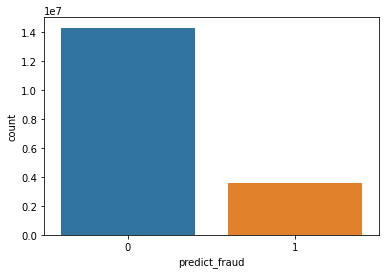

In [28]:
import seaborn as sns
sns.countplot(x='predict_fraud', data=test)

Plot feature importances...


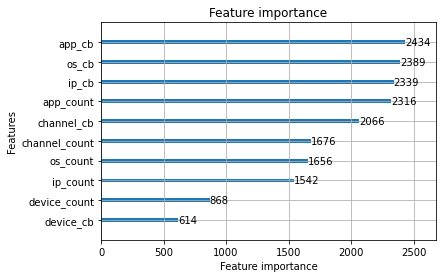

In [29]:
print('Plot feature importances...')
ax = lgb.plot_importance(lgbm_model, max_num_features=15)
plt.show()

In [30]:
feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

In [31]:
profile_df = test.groupby('predict_fraud').agg({'ip_cb': ['mean'],
                                               'app_cb': ['mean'],
                                               'os_cb': ['mean'],
                                               'device_cb': ['mean'],
                                               'channel_cb': ['mean'],
                                               'ip_count': ['mean'],
                                               'app_count': ['mean'],
                                               'os_count': ['mean'],
                                               'device_count': ['mean'],
                                               'channel_count': ['mean']
                                               })

# rename columns
profile_df.columns = ['ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb','ip_count', 'app_count', 'device_count','os_count', 'channel_count']

# reset index to get grouped columns back
profile_df = profile_df.reset_index()



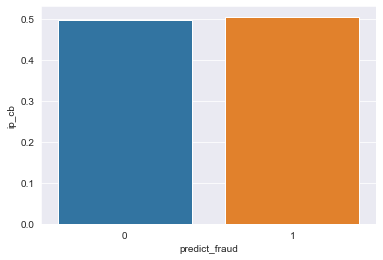

In [32]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "ip_cb", data = profile_df)
plt.show()

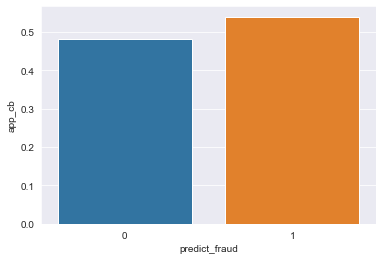

In [33]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "app_cb", data = profile_df)
plt.show()

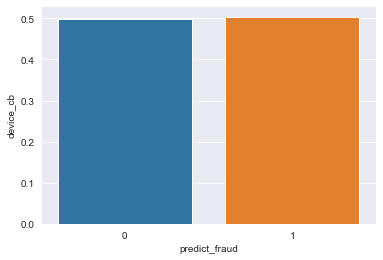

In [34]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "device_cb", data = profile_df)
plt.show()

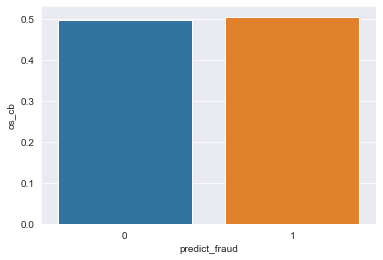

In [35]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "os_cb", data = profile_df)
plt.show()

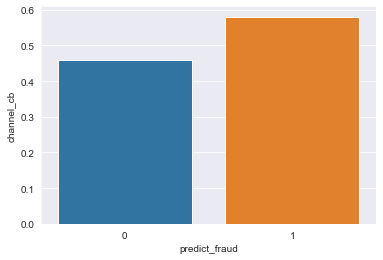

In [36]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "channel_cb", data = profile_df)
plt.show()

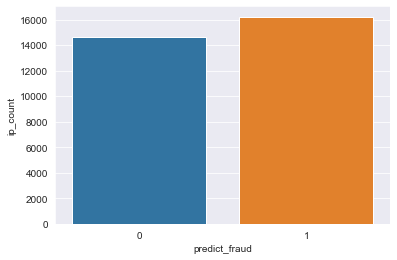

In [37]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "ip_count", data = profile_df)
plt.show()

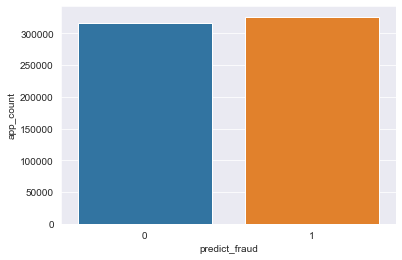

In [38]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "app_count", data = profile_df)
plt.show()

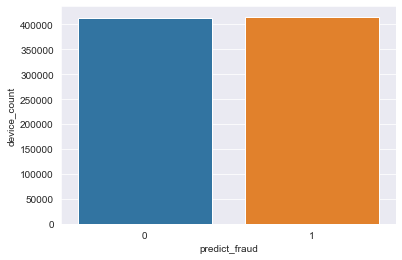

In [39]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "device_count", data = profile_df)
plt.show()

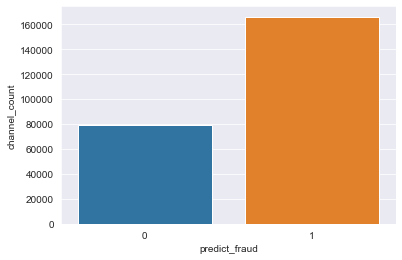

In [40]:
# Set Seaborn style
sns.set_style('darkgrid')


# Construct plot
sns.barplot(x = "predict_fraud", y = "channel_count", data = profile_df)
plt.show()

## Model Explainer - SHAP

In [41]:
import joblib
lgbm_model = joblib.load('lgb_count_cat_15s_v2.pkl')

feature_cols = ['ip_count', 'app_count', 'device_count','os_count', 'channel_count',
               'ip_cb', 'app_cb', 'device_cb','os_cb', 'channel_cb']

X_train = X_train[feature_cols]
X_test = test[feature_cols]

In [42]:
X_train

,ip_count,app_count,device_count,os_count,channel_count,ip_cb,app_cb,device_cb,os_cb,channel_cb
0,12276,55560,3316701,53689,12473,0.484035,0.479878,0.498937,0.488201,0.483045
1,15471,512619,3316701,840458,165114,0.520844,0.404328,0.498937,0.495007,0.235851
2,11648,512619,3316701,840458,49928,0.434415,0.404328,0.498937,0.495007,0.497316
3,15030,512619,3316701,77418,27664,0.519360,0.404328,0.498937,0.505412,0.489120
4,15118,512619,3316701,188410,165114,0.493849,0.404328,0.498937,0.510307,0.235851
...,...,...,...,...,...,...,...,...,...,...
3538853,10866,517660,3316701,54805,307245,0.499540,0.529711,0.498937,0.494061,0.653803
3538854,17571,517660,3316701,100006,161586,0.534344,0.529711,0.498937,0.494880,0.559702
3538855,13365,398151,3316701,37683,161586,0.500112,0.565574,0.498937,0.492716,0.559702
3538856,13336,44739,3316701,102167,35772,0.509672,0.613601,0.498937,0.503000,0.588111


In [ ]:
import shap

%time shap_values = shap.TreeExplainer(lgbm_model).shap_values(X_train)


In [ ]:
shap.summary_plot(shap_values, valid_x)
